In [0]:
!pip install torch

    100% |████████████████████████████████| 591.8MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61c3a000 @  0x7f60a72582a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
!pip install torchvision

    100% |████████████████████████████████| 61kB 2.1MB/s 
    100% |████████████████████████████████| 2.0MB 12.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
from torchvision import transforms, datasets ,utils


 

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count
# answers = np.load('gan-checks-tf.npz')

print('Done')

Done


## 1 To DO:

In [0]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    ###############
    ##1st TO DO (4 points)
    #################
    print(batch_size,dim)
    noise= torch.rand(batch_size, dim)*2-1
    print(noise.max(),noise.min())
    #toch.rand return valeus between [0,1] from uniform distribution multiply by 2 makes in between 0 and 2 and then sum wit -1 makes it between -1 to 1
  
    return noise



In [0]:
  def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')
    
test_sample_noise()

3 4
tensor(0.7996) tensor(-0.9413)
All tests passed!


Processing...
Done!


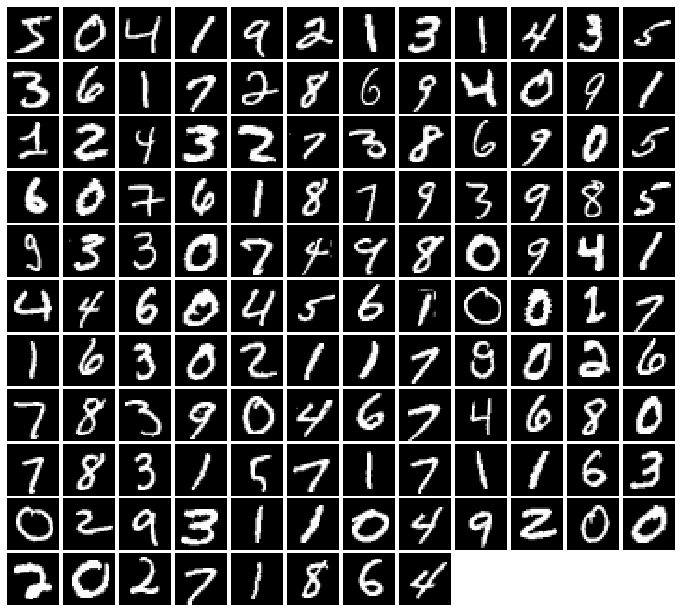

In [0]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 100
batch_size = 128

mnist_train = dset.MNIST('./data/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./data/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform(m.weight.data)

In [0]:
dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!


## 2 To DO:  Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Reshape into image tensor (Use Unflatten!)
* 36 Filters, 4x4, Stride 1, Leaky ReLU(alpha=0.02)
* Max Pool 2x2, Stride 2
* 72 Filters, 4x4, Stride 1, Leaky ReLU(alpha=0.02)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected output size 1024, Leaky ReLU(alpha=0.02)
* Fully Connected output size 1

In [0]:
def build_dc_classifier():#mnist
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return nn.Sequential(
        ###########################
        #########2nd TO DO (10 points)###########
        ###########################
        Unflatten(batch_size, 1, 28, 28),        
        nn.Conv2d(1, 36, kernel_size=4, stride=1),
        nn.LeakyReLU(0.02, inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(36, 72, kernel_size=4, stride=1),
        nn.LeakyReLU(0.02, inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        Flatten(),
        nn.Linear(1152,1024),
        nn.LeakyReLU(0.02, inplace=True),
        nn.Linear(1024,1)
        
        
    )

In [0]:
def test_dc_classifer(true_count=1223853):
    model = build_dc_classifier()
    cur_count = count_params(model)
    if cur_count != true_count:
        print(cur_count)
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_classifer()

Correct number of parameters in generator.


## 3 To Do: Generator.
See the document for documentation for [ConvTranspose2d](http://pytorch.org/docs/master/nn.html?highlight=convtranspose2d#torch.nn.ConvTranspose2d). 

* Fully connected of size 1500, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 120, ReLU
* BatchNorm
* Reshape into Image Tensor using Unflatten(), you should figure out the parameters of N,C,H and W.
* 60 ConvTranspose2d filters of 4x4, stride 2,  padding=1, ReLU
* BatchNorm
* 1 ConvTranspose2d filter of 4x4, stride 2, padding=1, TanH
* Should have a 28x28x1 image, reshape back into 784 vector

In [0]:
def build_dc_generator(noise_dim=NOISE_DIM):#mnist
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    return nn.Sequential(
        #########3rd TO DO (10 points)###########
        nn.Linear(noise_dim, 1500),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(1500),
        
        nn.Linear(1500, 7*7*120),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(120*7*7),
        
        Unflatten(batch_size, 120, 7, 7),
        
        nn.ConvTranspose2d(120, 60, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(60),
        
        nn.ConvTranspose2d(60, 1, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
        Flatten()    
        
    )

In [0]:
def test_dc_generator(true_count=9108481):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print(cur_count)
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

In [0]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Variable of shape (N, ) giving scores.
    - target: PyTorch Variable of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Variable containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

## 4 and 5 To Do

In [0]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    ##########4th TO DO (5 points)#############
    #print(f"{logits_real.shape[0]}")
    #print(f"{logits_fake.shape[0]}")
    true_labels = Variable(torch.ones(128)).type(dtype)
    fake_labels = Variable(torch.zeros(128)).type(dtype)
    real_loss = bce_loss(logits_real, true_labels) #loss on true images
    fake_loss = bce_loss(logits_fake, fake_labels) #loss on fake images
    print("NOw D")
    return real_loss + fake_loss


    

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    #-log(1 / (1 + exp(-x)))
    #####5th TO DO (3 points)########
    labels = Variable(torch.ones(128)).type(dtype)
    #print(labels.shape)
    loss=bce_loss(logits_fake, labels)
    print("NOw G")
    return loss

In [0]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(Variable(torch.Tensor(logits_real)).type(dtype),
                                Variable(torch.Tensor(logits_fake)).type(dtype)).data.cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

#test_discriminator_loss(answers['logits_real'], answers['logits_fake'],answers['d_loss_true'])

In [0]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(Variable(torch.Tensor(logits_fake)).type(dtype)).data.cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))
  
#test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

## 6th To Do:

In [0]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 2e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    #########6th TO DO (3 points)###############
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, betas=(0.6, 0.999))  
    #print(f"optim: {z}, dtype: {type(z)}")
    return optimizer
  #Done

In [0]:
test_model = build_dc_classifier()
z = get_optimizer(test_model)
print(f"optim: {z}, dtype: {type(z)}")

optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
), dtype: <class 'torch.optim.adam.Adam'>


In [0]:
import time
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=100, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    t1=time.time()
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            t2=time.time()
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = Variable(x).type(dtype)
            real_data=real_data.view(batch_size,1,784)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)
            fake_images=fake_images.detach()
            
            logits_fake = D(fake_images.view(batch_size, 1, 784))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 784))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item())) #changes made
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print('total time: %.2f'%(time.time()-t1))
                print('100 iter time: %.2f'%(time.time()-t2))
                print()
            iter_count += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


start training
128 100
tensor(0.9999) tensor(-1.0000)
NOw D
128 100
tensor(0.9999) tensor(-1.0000)
NOw G
Iter: 0, D: 1.387, G:0.01282


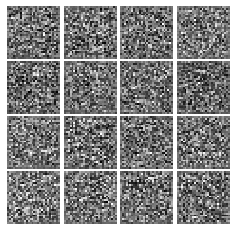

total time: 0.93
100 iter time: 0.92

128 100
tensor(0.9999) tensor(-0.9996)
NOw D
128 100
tensor(1.0000) tensor(-0.9997)
NOw G
128 100
tensor(1.0000) tensor(-1.0000)
NOw D
128 100
tensor(0.9997) tensor(-0.9997)
NOw G
128 100
tensor(1.0000) tensor(-1.0000)
NOw D
128 100
tensor(0.9999) tensor(-0.9999)
NOw G
128 100
tensor(0.9998) tensor(-1.0000)
NOw D
128 100
tensor(0.9998) tensor(-1.0000)
NOw G
128 100
tensor(1.0000) tensor(-0.9998)
NOw D
128 100
tensor(1.0000) tensor(-1.0000)
NOw G
128 100
tensor(0.9998) tensor(-0.9996)
NOw D
128 100
tensor(0.9999) tensor(-0.9999)
NOw G
128 100
tensor(0.9994) tensor(-0.9998)
NOw D
128 100
tensor(0.9998) tensor(-0.9996)
NOw G
128 100
tensor(0.9993) tensor(-0.9999)
NOw D
128 100
tensor(1.0000) tensor(-0.9993)
NOw G
128 100
tensor(1.0000) tensor(-0.9995)
NOw D
128 100
tensor(0.9996) tensor(-0.9998)
NOw G
128 100
tensor(0.9998) tensor(-0.9998)
NOw D
128 100
tensor(0.9999) tensor(-0.9999)
NOw G
128 100
tensor(1.0000) tensor(-0.9999)
NOw D
128 100
tensor(1.

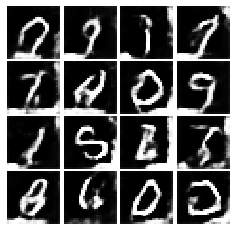

total time: 16.48
100 iter time: 1.05

128 100
tensor(0.9999) tensor(-0.9999)
NOw D
128 100
tensor(0.9998) tensor(-0.9999)
NOw G
128 100
tensor(0.9999) tensor(-0.9998)
NOw D
128 100
tensor(0.9999) tensor(-0.9999)
NOw G
128 100
tensor(1.0000) tensor(-0.9997)
NOw D
128 100
tensor(0.9999) tensor(-0.9998)
NOw G
128 100
tensor(0.9995) tensor(-0.9999)
NOw D
128 100
tensor(1.0000) tensor(-0.9996)
NOw G
128 100
tensor(0.9998) tensor(-0.9998)
NOw D
128 100
tensor(1.0000) tensor(-0.9997)
NOw G
128 100
tensor(0.9999) tensor(-0.9997)
NOw D
128 100
tensor(0.9999) tensor(-0.9997)
NOw G
128 100
tensor(0.9998) tensor(-0.9999)
NOw D
128 100
tensor(0.9998) tensor(-0.9998)
NOw G
128 100
tensor(0.9999) tensor(-1.0000)
NOw D
128 100
tensor(0.9999) tensor(-0.9999)
NOw G
128 100
tensor(0.9999) tensor(-0.9997)
NOw D
128 100
tensor(1.0000) tensor(-0.9998)
NOw G
128 100
tensor(0.9999) tensor(-1.0000)
NOw D
128 100
tensor(0.9998) tensor(-0.9999)
NOw G
128 100
tensor(1.0000) tensor(-0.9997)
NOw D
128 100
tensor(0

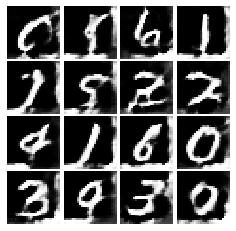

total time: 31.85
100 iter time: 0.93

128 100
tensor(0.9999) tensor(-0.9992)
NOw D
128 100
tensor(1.0000) tensor(-1.0000)
NOw G
128 100
tensor(0.9998) tensor(-0.9999)
NOw D
128 100
tensor(1.0000) tensor(-0.9997)
NOw G
128 100
tensor(0.9999) tensor(-0.9996)
NOw D
128 100
tensor(0.9999) tensor(-1.0000)
NOw G
128 100
tensor(1.0000) tensor(-0.9999)
NOw D
128 100
tensor(0.9997) tensor(-0.9999)
NOw G
128 100
tensor(1.0000) tensor(-1.0000)
NOw D
128 100
tensor(0.9993) tensor(-0.9995)
NOw G
128 100
tensor(1.0000) tensor(-0.9997)
NOw D
128 100
tensor(0.9995) tensor(-1.0000)
NOw G
128 100
tensor(0.9999) tensor(-0.9997)
NOw D
128 100
tensor(1.0000) tensor(-0.9997)
NOw G
128 100
tensor(0.9997) tensor(-0.9999)
NOw D
128 100
tensor(1.0000) tensor(-1.0000)
NOw G
128 100
tensor(0.9994) tensor(-0.9999)
NOw D
128 100
tensor(0.9997) tensor(-0.9999)
NOw G
128 100
tensor(0.9999) tensor(-0.9998)
NOw D
128 100
tensor(1.0000) tensor(-0.9997)
NOw G
128 100
tensor(0.9997) tensor(-0.9999)
NOw D
128 100
tensor(0

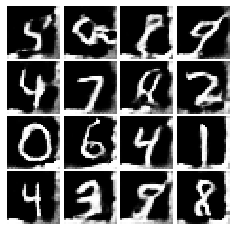

total time: 47.35
100 iter time: 1.02

128 100
tensor(1.0000) tensor(-1.0000)
NOw D
128 100
tensor(1.0000) tensor(-0.9998)
NOw G
128 100
tensor(1.0000) tensor(-0.9999)
NOw D
128 100
tensor(0.9997) tensor(-0.9996)
NOw G
128 100
tensor(0.9999) tensor(-0.9999)
NOw D
128 100
tensor(0.9997) tensor(-1.0000)
NOw G
128 100
tensor(0.9999) tensor(-0.9996)
NOw D
128 100
tensor(1.0000) tensor(-0.9998)
NOw G
128 100
tensor(0.9994) tensor(-0.9997)
NOw D
128 100
tensor(0.9999) tensor(-1.0000)
NOw G
128 100
tensor(0.9995) tensor(-0.9996)
NOw D
128 100
tensor(0.9998) tensor(-0.9998)
NOw G
128 100
tensor(0.9999) tensor(-0.9996)
NOw D
128 100
tensor(1.0000) tensor(-0.9999)
NOw G
128 100
tensor(0.9998) tensor(-0.9993)
NOw D
128 100
tensor(0.9998) tensor(-0.9996)
NOw G
128 100
tensor(0.9996) tensor(-1.0000)
NOw D
128 100
tensor(1.0000) tensor(-0.9999)
NOw G
128 100
tensor(0.9999) tensor(-0.9998)
NOw D
128 100
tensor(0.9998) tensor(-0.9996)
NOw G
128 100
tensor(0.9999) tensor(-1.0000)
NOw D
128 100
tensor(1

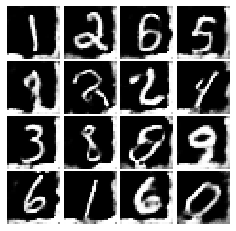

total time: 62.76
100 iter time: 0.94

128 100
tensor(0.9997) tensor(-0.9998)
NOw D
128 100
tensor(0.9999) tensor(-1.0000)
NOw G
128 100
tensor(1.0000) tensor(-1.0000)
NOw D
128 100
tensor(0.9999) tensor(-0.9997)
NOw G
128 100
tensor(1.0000) tensor(-0.9997)
NOw D
128 100
tensor(0.9996) tensor(-0.9999)
NOw G
128 100
tensor(0.9999) tensor(-0.9997)
NOw D
128 100
tensor(0.9997) tensor(-0.9999)
NOw G
128 100
tensor(0.9999) tensor(-0.9999)
NOw D
128 100
tensor(0.9997) tensor(-1.0000)
NOw G
128 100
tensor(0.9998) tensor(-1.0000)
NOw D
128 100
tensor(0.9999) tensor(-1.0000)
NOw G
128 100
tensor(1.0000) tensor(-0.9997)
NOw D
128 100
tensor(0.9997) tensor(-0.9997)
NOw G
128 100
tensor(1.0000) tensor(-0.9999)
NOw D
128 100
tensor(0.9999) tensor(-0.9999)
NOw G
128 100
tensor(1.0000) tensor(-0.9999)
NOw D
128 100
tensor(0.9999) tensor(-0.9999)
NOw G
128 100
tensor(0.9997) tensor(-0.9998)
NOw D
128 100
tensor(0.9999) tensor(-0.9997)
NOw G
128 100
tensor(0.9999) tensor(-0.9998)
NOw D
128 100
tensor(0

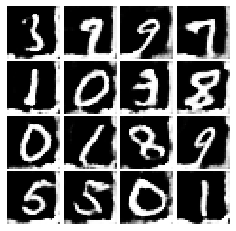

total time: 78.19
100 iter time: 1.01

128 100
tensor(1.0000) tensor(-0.9995)
NOw D
128 100
tensor(1.0000) tensor(-0.9997)
NOw G
128 100
tensor(0.9997) tensor(-0.9998)
NOw D
128 100
tensor(0.9999) tensor(-1.0000)
NOw G
128 100
tensor(0.9997) tensor(-0.9999)
NOw D
128 100
tensor(0.9999) tensor(-0.9996)
NOw G
128 100
tensor(0.9999) tensor(-0.9999)
NOw D
128 100
tensor(0.9997) tensor(-0.9999)
NOw G
128 100
tensor(1.0000) tensor(-0.9997)
NOw D
128 100
tensor(0.9996) tensor(-0.9996)
NOw G
128 100
tensor(0.9999) tensor(-0.9998)
NOw D
128 100
tensor(0.9999) tensor(-1.0000)
NOw G
128 100
tensor(0.9995) tensor(-1.0000)
NOw D
128 100
tensor(0.9997) tensor(-0.9999)
NOw G
128 100
tensor(1.0000) tensor(-1.0000)
NOw D
128 100
tensor(0.9997) tensor(-0.9999)
NOw G
128 100
tensor(1.0000) tensor(-0.9999)
NOw D
128 100
tensor(1.0000) tensor(-0.9999)
NOw G
128 100
tensor(0.9999) tensor(-0.9999)
NOw D
128 100
tensor(0.9997) tensor(-1.0000)
NOw G
128 100
tensor(1.0000) tensor(-0.9994)
NOw D
128 100
tensor(0

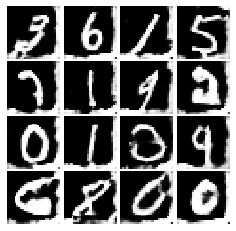

total time: 93.57
100 iter time: 0.94

128 100
tensor(0.9996) tensor(-0.9999)
NOw D
128 100
tensor(1.0000) tensor(-0.9998)
NOw G
128 100
tensor(0.9998) tensor(-0.9999)
NOw D
128 100
tensor(0.9999) tensor(-1.0000)
NOw G
128 100
tensor(1.0000) tensor(-0.9997)
NOw D
128 100
tensor(0.9999) tensor(-0.9996)
NOw G
128 100
tensor(0.9991) tensor(-0.9998)
NOw D
128 100
tensor(0.9998) tensor(-1.0000)
NOw G
128 100
tensor(0.9998) tensor(-0.9999)
NOw D
128 100
tensor(0.9999) tensor(-0.9995)
NOw G
128 100
tensor(0.9997) tensor(-0.9999)
NOw D
128 100
tensor(0.9999) tensor(-0.9998)
NOw G
128 100
tensor(0.9999) tensor(-0.9995)
NOw D
128 100
tensor(0.9999) tensor(-1.0000)
NOw G
128 100
tensor(0.9999) tensor(-1.0000)
NOw D
128 100
tensor(0.9993) tensor(-1.0000)
NOw G
128 100
tensor(0.9997) tensor(-0.9998)
NOw D
128 100
tensor(0.9998) tensor(-0.9999)
NOw G
128 100
tensor(1.0000) tensor(-1.0000)
NOw D
128 100
tensor(0.9999) tensor(-0.9999)
NOw G
128 100
tensor(0.9998) tensor(-1.0000)
NOw D
128 100
tensor(1

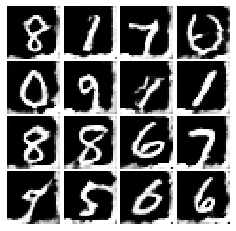

total time: 109.06
100 iter time: 1.03

128 100
tensor(0.9994) tensor(-1.0000)
NOw D
128 100
tensor(0.9997) tensor(-1.0000)
NOw G
128 100
tensor(0.9998) tensor(-0.9998)
NOw D
128 100
tensor(0.9997) tensor(-0.9999)
NOw G
128 100
tensor(1.0000) tensor(-0.9999)
NOw D
128 100
tensor(0.9994) tensor(-0.9999)
NOw G
128 100
tensor(1.0000) tensor(-0.9997)
NOw D
128 100
tensor(0.9999) tensor(-1.0000)
NOw G
128 100
tensor(0.9998) tensor(-0.9999)
NOw D
128 100
tensor(0.9996) tensor(-0.9999)
NOw G
128 100
tensor(0.9998) tensor(-0.9999)
NOw D
128 100
tensor(1.0000) tensor(-0.9999)
NOw G
128 100
tensor(1.0000) tensor(-0.9999)
NOw D
128 100
tensor(0.9999) tensor(-1.0000)
NOw G
128 100
tensor(0.9999) tensor(-0.9999)
NOw D
128 100
tensor(1.0000) tensor(-0.9999)
NOw G
128 100
tensor(0.9999) tensor(-0.9998)
NOw D
128 100
tensor(0.9993) tensor(-0.9999)
NOw G
128 100
tensor(0.9997) tensor(-1.0000)
NOw D
128 100
tensor(1.0000) tensor(-0.9993)
NOw G
128 100
tensor(0.9999) tensor(-0.9998)
NOw D
128 100
tensor(

In [0]:
# Make the discriminator
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
# Make the generator
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)
# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)
t1=time.time()
print('start training')
# Run it!
run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=5)
print(time.time()-t1)

## To Do 7: Inline Question
1.Exaplain how the ditribution of images change through iterations. (1 point) 2.Explain why the loss of D cannot converge to around 0? What would happen if loss of D is very small and loss of G is very large at the end of training? Is this a prefered situation for generating images that look real? (3 points)



####Ans:
* 1: During first iterations output was very very noisy. Generator was not trained at all. Around 500 we can observe the vauge figures, after 1000 itrations we can distinguishly see integers. The generator has learned. 
* 2 : If discrimnator loss is zero then it means generator is not making any releven output. In adversarial training protocol, generator has to learn to fool descriminator, so loss of descrimnator should not converge to zero.
* 3 : If descrimnator loss is very small menas it can clearly distinguish between real and generated images, while if generato loss is high means it giving random output that is output is not similer to target images, so this is very undesirable situation. No, it is not perfect situation for generating images that look real.